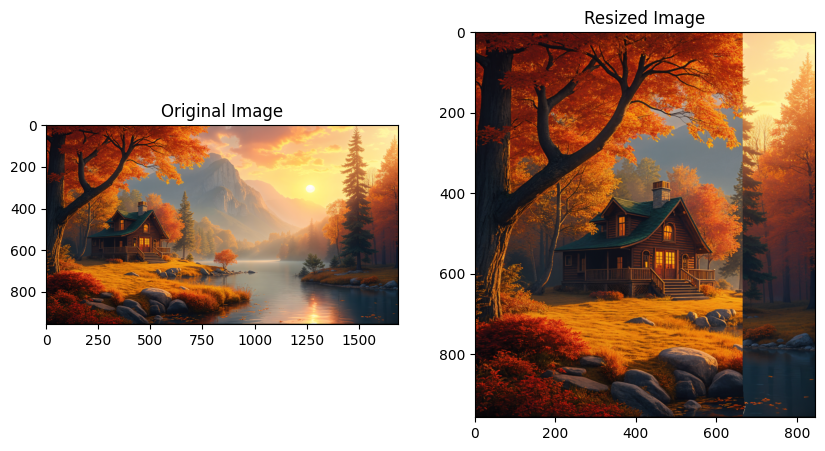

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_energy(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    dx = np.abs(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3))
    dy = np.abs(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3))
    energy = dx + dy
    return energy

def find_vertical_seam(energy):
    rows, cols = energy.shape
    seam = np.zeros(rows, dtype=np.int32)
    dp = energy.copy()
    backtrack = np.zeros((rows, cols), dtype=np.int32)
    
    for i in range(1, rows):
        for j in range(cols):
            min_energy = dp[i-1, j]
            min_index = j
            if j > 0 and dp[i-1, j-1] < min_energy:
                min_energy = dp[i-1, j-1]
                min_index = j-1
            if j < cols-1 and dp[i-1, j+1] < min_energy:
                min_energy = dp[i-1, j+1]
                min_index = j+1
            
            dp[i, j] += min_energy
            backtrack[i, j] = min_index
    
    seam[-1] = np.argmin(dp[-1])
    for i in range(rows-2, -1, -1):
        seam[i] = backtrack[i+1, seam[i+1]]
    
    return seam

def remove_seam(img, seam):
    rows, cols, _ = img.shape
    output = np.zeros((rows, cols-1, 3), dtype=np.uint8)
    for i in range(rows):
        output[i, :, :] = np.delete(img[i, :, :], seam[i], axis=0)
    return output

def update_energy_map(energy, img, seam):
    rows, cols = energy.shape
    for i in range(rows):
        col = seam[i]
        start = max(col - 1, 0)
        end = min(col + 2, cols - 1)
        gray = cv2.cvtColor(img[i : i + 1, start:end], cv2.COLOR_BGR2GRAY)
        dx = np.abs(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3))
        dy = np.abs(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3))
        energy[i, start:end] = dx + dy
    return energy

def seam_carving_optimized(img, num_seams):
    energy = compute_energy(img)
    for _ in range(num_seams):
        seam = find_vertical_seam(energy)
        img = remove_seam(img, seam)
        energy = update_energy_map(energy, img, seam)  # Incremental energy update
    return img

# Load and process the image
image_path = "C:\\Users\\dell\\OneDrive\\Pictures\\Screenshots\\wall.jpg"
input_image = cv2.imread(image_path)

if input_image is None:
    raise FileNotFoundError(f"Image file '{image_path}' not found or could not be loaded. Check the file path and format.")

# Reduce width by half
num_seams_to_remove = input_image.shape[1] // 2
resized_image = seam_carving_optimized(input_image, num_seams_to_remove)
cv2.imwrite('resized_output.jpg', resized_image)

# Show result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
plt.title('Resized Image')
plt.show()
